# Matched Filter Techniques

### Jeff McMahon and Renée Hložek 

We have seen how to extract an estimate for the power spectrum from a CMB map.  In this exercise we extract the point sources from our simulated maps.  We do this using the matched filter technqiue. 

## First we read in the necessary libraries.

In [1]:
import numpy as np
import matplotlib
import sys
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits


%matplotlib inline
import constants as cs # the constants module

from cmb_modules import * # the module of functions

N = cs.N
N_iterations = cs.N_iterations
c_min = cs.c_min
c_max = cs.c_max
X_width =cs.X_width
Y_width = cs.Y_width
beam_size_fwhp = cs.beam_size_fwhp

pix_size = cs.pix_size

Number_of_Sources  = cs.Number_of_Sources
Amplitude_of_Sources = cs.Amplitude_of_Sources
Number_of_Sources_EX = cs.Number_of_Sources_EX
Amplitude_of_Sources_EX = cs.Amplitude_of_Sources_EX

Number_of_SZ_Clusters  = cs.Number_of_SZ_Clusters
Mean_Amplitude_of_SZ_Clusters = cs.Mean_Amplitude_of_SZ_Clusters
SZ_beta = cs.SZ_beta
SZ_Theta_core = cs.SZ_Theta_core

white_noise_level = cs.white_noise_level
atmospheric_noise_level = 0#cs.atmospheric_noise_level
one_over_f_noise_level = 0#cs.one_over_f_noise_level

### rebuildng the simulated map from previous excercises

Number of sources required:  5000
map mean: 8.913782528365509 map rms: 98.16513635981514


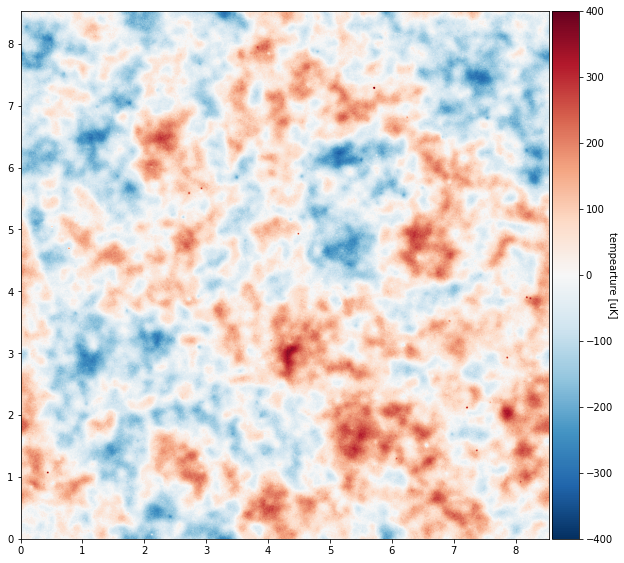

In [2]:
## Make a CMB map
ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 
CMB_T = make_CMB_T_map(N,pix_size,ell,DlTT)

N=int(N)
## make a point source map
PSMap = Poisson_source_component(N,pix_size,Number_of_Sources,Amplitude_of_Sources) 
PSMap +=  Exponential_source_component(N,pix_size,Number_of_Sources_EX,Amplitude_of_Sources_EX)

## make an SZ map
SZMap,SZCat = SZ_source_component(N,pix_size,Number_of_SZ_Clusters,Mean_Amplitude_of_SZ_Clusters,SZ_beta,SZ_Theta_core,False)

## add them all together to get the sky map at a single freuqency
total_map = CMB_T + PSMap + SZMap

## incorperate the impact of the instrument
    ## beam
CMB_T_convolved =convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,total_map)
    ## noise
Noise = make_noise_map(N,pix_size,white_noise_level,atmospheric_noise_level,one_over_f_noise_level)

total_map_plus_noise = CMB_T_convolved + Noise

total_map_plus_noise_original = total_map_plus_noise
SZCat_original = SZCat
## plot the result
p=Plot_CMB_Map(total_map_plus_noise,c_min,c_max,X_width,Y_width)

## we will need a window funciton below, so we creat that here
window = (cosine_window(N))

A few point sources and SZ sources are visible in our simulated map, however there are many that are faint and difficult to identify.  There are sophisticated techniques for isolating these sources.  We now discuss the matched filter approach.

### Constructing a matcher filter

We construct a single frequency matched filter following Melin etc...  the punch line is that we build the following filter in fourier space:

$$\psi = \frac{B_\ell S_\ell }{B_\ell^2 N^2_{ap,\ell} +N^2_{ins,\ell} } $$

Both $\psi$ and all the other quantities are two dimensional in the since that they depend on $k_x$ and $k_y$.  We refer to these coordinates with a $\ell$ as shorthand.   In this equation $B_\ell$ is the Fourier transform of the beam pattern and filtering; $S_\ell$ is the Fourier transform of the signal template; $N^2_{ap,\ell}$ is the power spectrum (e.g., absolute value squared of the 2d FFT) of the astrophysical noise from sources other than what is desired to be found, and $N^2_{ins,\ell}$ is the power spectrum of the instrumental response.


In the next box we define a funciton to calculate the matched filter and a funciton to plot the resulting map.   In subsequent boxes we do the work of estimating the terms in the filter. 

In [3]:
def matched_filter(input_map,beam_and_filt,signal_profile,FT_noise_covar):
    ## input_map: the map we are processing
    ## beam_and_filt: the beam convolved with any map filtering, in real space
    ## signal_profile: the shape of the signal we are looking for, in real spcae
    ## FT_noise_covar: the B_N_{ap}^2 + N_{ins}^2 in fourier space
             ## calculating FT_npoise_covar is expensive so it is done externally
        
    FT_beam_and_filt = np.fft.fft2(np.fft.fftshift(beam_and_filt))  ## tranform beam_and_filt to fourier space
    FT_signal = np.fft.fft2(np.fft.fftshift(signal_profile))       ## tranform cluster_profile to fourier space
    
    psi = FT_beam_and_filt * FT_signal / FT_noise_covar             ## define the matchedfilter funciton
    
    filtered = psi * np.fft.fft2(np.fft.fftshift(input_map))        ## filter the map
    filtered = np.fft.fftshift(np.fft.ifft2(filtered))              ## center the filter
    filtered = np.real(filtered)                                    ## change the data type to real
    return(filtered)


def Plot_Matched_Filtered_Map(Map_to_Plot,X_width,Y_width):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    print("map mean:",np.mean(Map_to_Plot),"map rms:",np.std(Map_to_Plot))
    plt.figure(figsize=[10,10])
    im = plt.imshow(Map_to_Plot, interpolation='bilinear', origin='lower',cmap=cm.RdBu_r)
    #im.set_clim(c_min,c_max)
    ax=plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    im.set_extent([0,X_width,0,Y_width])
    plt.ylabel('angle $[^\circ]$')
    plt.xlabel('angle $[^\circ]$')
    cbar.set_label('matched_filter [S/N]', rotation=270)
    plt.show()
    return(0)
  ###############################

Following what we did above to compute the power spectrum, we will calculate the noice covariance (the denominator of in matched filter definition) using monty carlo techniques.

In [4]:
## construct the 2d noise noise covariance in fourier space
FT_noise_covar = np.zeros((N,N))  ## a 2d array to hold the result
     
N_iterations = 16

## make a series of simulated maps, find the power spectrum, and average these to esitmae the noise covariance
i = 0
while (i <N_iterations):
    ## sumilate the astrophysical map
    CMB_T = make_CMB_T_map(N,pix_size,ell,DlTT)
    PSMap = Poisson_source_component(N,pix_size,Number_of_Sources,Amplitude_of_Sources) 
    PSMap +=  Exponential_source_component(N,pix_size,Number_of_Sources_EX,Amplitude_of_Sources_EX)
    SZMap,trash = SZ_source_component(N,pix_size,Number_of_SZ_Clusters,Mean_Amplitude_of_SZ_Clusters,SZ_beta,SZ_Theta_core,False)
    CMB_T  = CMB_T + PSMap + SZMap  ## the astrophysical map
    
    ## fold in the instrument response
    CMB_T_convolved = convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,CMB_T)
    Noise = make_noise_map(N,pix_size,white_noise_level,atmospheric_noise_level,one_over_f_noise_level)
    
    ## fourier trasfomr the map
    temp =  np.fft.fft2(np.fft.fftshift(window* (CMB_T_convolved + Noise)))  ## these are the two terms in the denominator

    ## now average
    FT_noise_covar += np.real(np.conj(temp)*temp/(N_iterations*1.0))
    ## note the progress
    sys.stdout.write("\r matched filter noise realization, iterations complete: %d of %d" % ((i+1),N_iterations) )
    sys.stdout.flush()
    ## iterate
    i = i + 1

Number of sources required:  5000
 matched filter noise realization, iterations complete: 1 of 16Number of sources required:  5000
 matched filter noise realization, iterations complete: 2 of 16Number of sources required:  5000
 matched filter noise realization, iterations complete: 3 of 16Number of sources required:  5000
 matched filter noise realization, iterations complete: 4 of 16Number of sources required:  5000
 matched filter noise realization, iterations complete: 5 of 16Number of sources required:  5000
 matched filter noise realization, iterations complete: 6 of 16Number of sources required:  5000
 matched filter noise realization, iterations complete: 7 of 16Number of sources required:  5000
 matched filter noise realization, iterations complete: 8 of 16Number of sources required:  5000
 matched filter noise realization, iterations complete: 9 of 16Number of sources required:  5000
 matched filter noise realization, iterations complete: 10 of 16Number of sources required:  

Now that we have the noise covariance and a function to compute the matched filter we filter our map.   To interpret this map we will divide by the standard deviation of the filtered map to put our map in signal to noise units.   

You can play around with the number of iterations you use in the Monty Carlo of the noise term.  If it is too small you will get high frequency ringing.

map mean: 8.913782528365509 map rms: 98.16513635981514


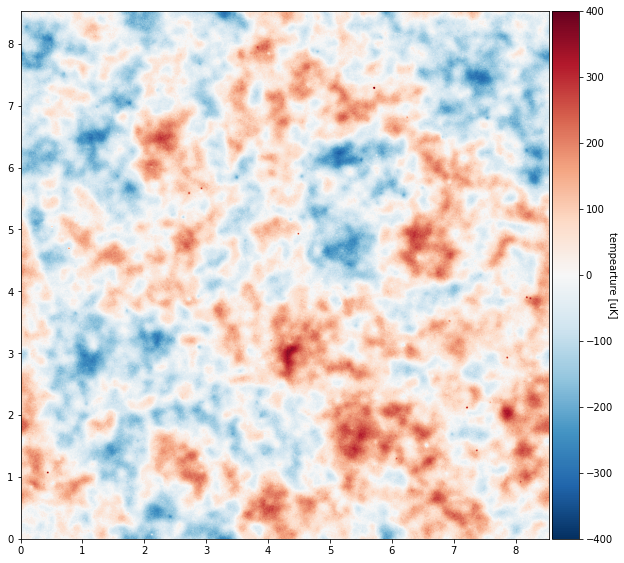

map mean: 0.00029491682536896067 map rms: 0.9999999999999998


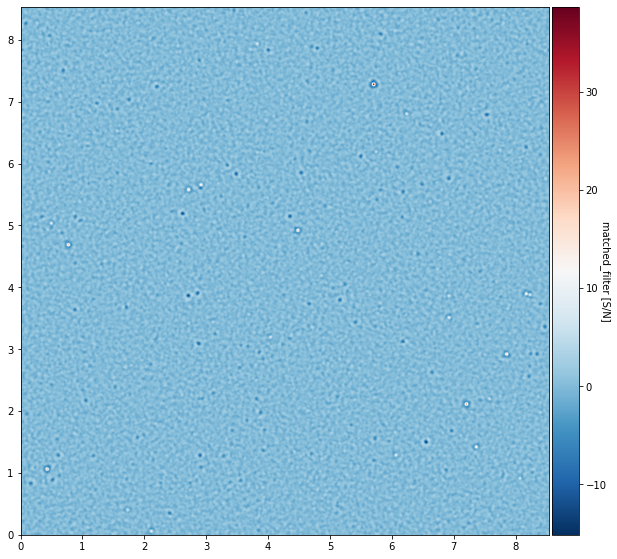

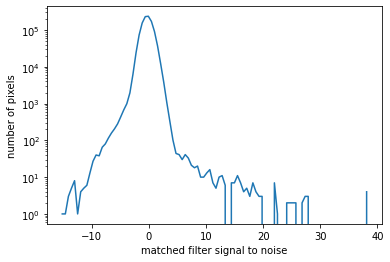

In [5]:
## construct the beam and cluster profile for the numerator of the matched filter
beam_and_filt = make_2d_gaussian_beam(N,pix_size,beam_size_fwhp)  ## this is the filtering we did on the map
cluster_profile = beta_function(N,pix_size,SZ_beta,SZ_Theta_core) ## this is the singnal we are looking for

## Apply the matched filter to our map
filtered_map = matched_filter(total_map_plus_noise_original,beam_and_filt,cluster_profile,FT_noise_covar)

## make a S/N map
SN_map = filtered_map / np.std(filtered_map)

## make a few plots
p = Plot_CMB_Map(total_map_plus_noise,c_min,c_max,X_width,Y_width)
p = Plot_Matched_Filtered_Map(SN_map,X_width,Y_width)

hist,bin_edges = np.histogram(SN_map,bins = 100,range=[SN_map.min(),SN_map.max()])
plt.semilogy(bin_edges[0:-1],hist)
plt.ylabel('number of pixels')
plt.xlabel('matched filter signal to noise')
plt.show()

Here we show three maps: (top) the raw simulated map, (middle) the matched filtered map, and (bottom) a histogram of the S/N of each pixel in the matched filter map.  You could identify SZ sources by doing a S/N cut and taking all the pixels below say -5.  To find point sources we would replace the beta function in the definition of the filter with a delta function and repeat the exercise looking for S/N greater than say 5.

NOTE: The signal to noise cut at $5 \sigma$ is not sacred.  It is chosen so that the probability of a spurious cluster (or point source) detection is controlled to be irrelevant on a ~100 degree patch with arcminute resolution.  Depending on the applicaiton this cut should be adjusted.

<font color='red'>EXCERCISE: </font>  Re-run this code with different the matched filter cluster radii on your map from part two that has multiple cluster radii and see how the S/N varries for different clusters.

In [6]:
## your code and plots go here

comment on your results here

<font color='red'>EXCERCISE: </font>  Make a matched filter for point sources.  Compar the S/N for SZ clusters and for point sources between this filtered map and the SZ filtered map.

map mean: 8.913782528365509 map rms: 98.16513635981514


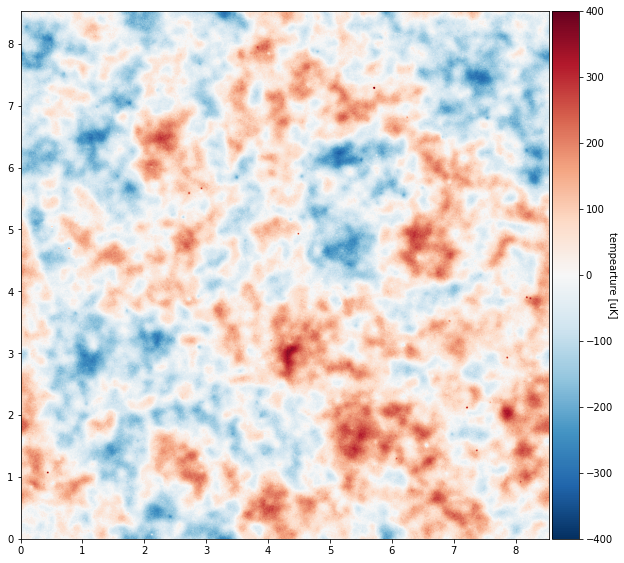

map mean: 6.106918152128191e-08 map rms: 0.9999999999999999


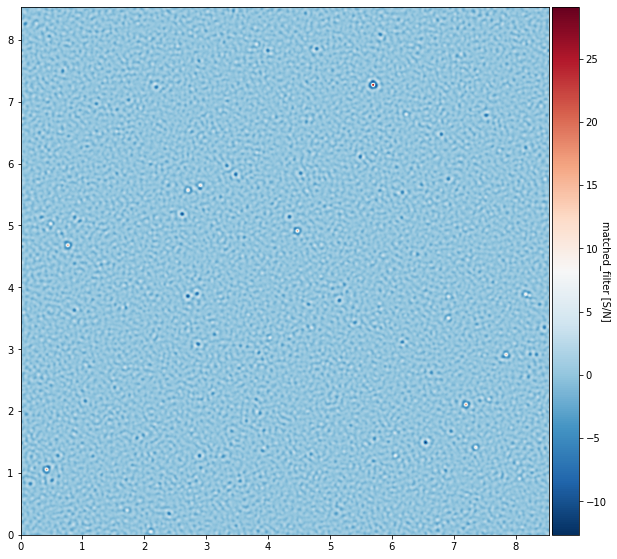

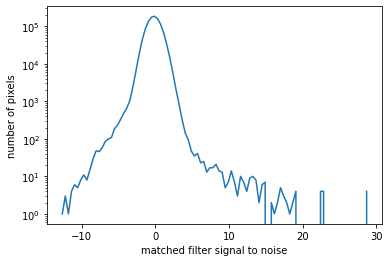

In [8]:
## your code and plots go here
## your code and plots go here
## construct the beam and cluster profile for the numerator of the matched filter
beam_and_filt = make_2d_gaussian_beam(N,pix_size,beam_size_fwhp)  ## this is the filtering we did on the map
cluster_profile = beta_function(N,pix_size,SZ_beta,SZ_Theta_core) ## this is the singnal we are looking for

## Apply the matched filter to our map
filtered_map = matched_filter(SN_map,beam_and_filt,cluster_profile,FT_noise_covar)

## make a S/N map
SN_map = filtered_map / np.std(filtered_map)

## make a few plots
p = Plot_CMB_Map(total_map_plus_noise,c_min,c_max,X_width,Y_width)
p = Plot_Matched_Filtered_Map(SN_map,X_width,Y_width)

hist,bin_edges = np.histogram(SN_map,bins = 100,range=[SN_map.min(),SN_map.max()])
plt.semilogy(bin_edges[0:-1],hist)
plt.ylabel('number of pixels')
plt.xlabel('matched filter signal to noise')
plt.show()

comment on your results here

<font color='red'>EXCERCISE: </font>  Extract a source list by (1) finding the highest S/N cluster detection, (2) set the pixels to zero within some radius of that cluster, and (3) iterate until you reach some S/N threshold.   Compare the source list you extract with the SZCat catalogue of true sources in the simulation.   

In [8]:
## your code and plots go here

comment on your results here

## Stacking

One often wants to understand signals at the low mass and therefore low signal to noise end of things.   If an external catalogue exists, one can co-add the signals from objects in the external catalogue to boost the signal to noise.   In this example we stack the simulated observed map and the matched filtered map at the positions of the  clusters we put into the simulation.  This highlights the opportunities that exist with stacking.  

Interpreting these results requires careful analysis.  Monte carlo simulations including selection effects and systematic effects are a particularly appealing approach.

C:\Users\dhanu\AppData\Local\Temp\ipykernel_11180\2846820953.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Radius = np.int(Radius)


map mean: 10.545600242493826 map rms: 3.8636746207204795


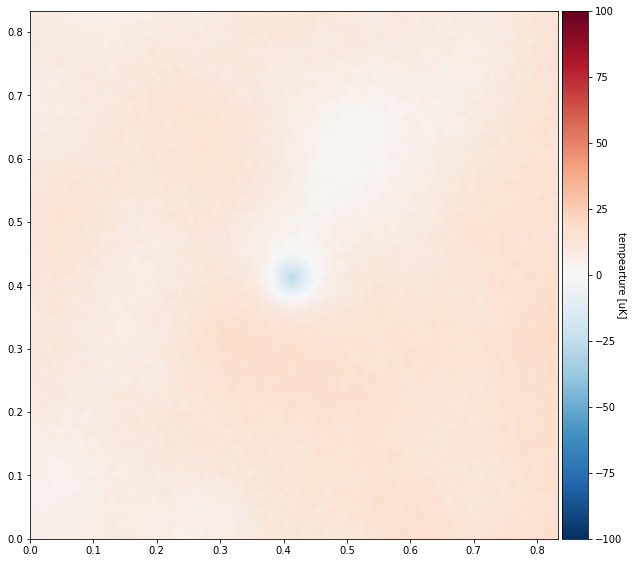

map mean: -0.00029920467830685813 map rms: 0.12220267979353316


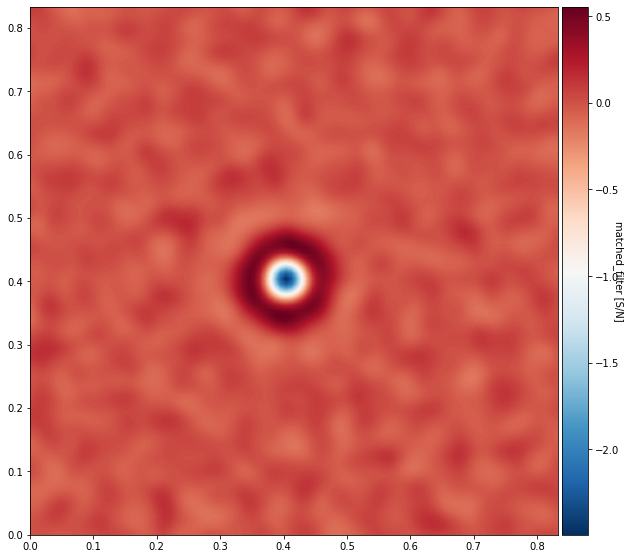

In [6]:
## take SZCat and stack total_map_plus_noise on the SZ positions, do this in a mass bin

def Stack_on_Positions(map,N,cat,N_objects,bin_min,bin_max,Radius):
    Radius = np.int(Radius)
    stack = np.zeros([Radius*2,Radius*2])
    counter = 0
    i = 0
    while (i < N_objects):
        ampl = cat[2,i]
        if ((ampl > bin_min) and (ampl <= bin_max)):
            xc = cat[0,i]
            yc = cat[1,i]
            if ((xc > Radius) and (xc < N-Radius)):
                if ((yc > Radius) and (yc < N-Radius)):
                    
                    stack += map[int(xc-Radius):int(xc+Radius),int(yc-Radius):int(yc+Radius)]
                    counter +=1
        i = i + 1
    return(stack/counter)



stack = Stack_on_Positions(total_map_plus_noise,N,SZCat,Number_of_SZ_Clusters,-100000,100000,50)
stack_SN = Stack_on_Positions(SN_map,N,SZCat,Number_of_SZ_Clusters,-100000,100000,50)

p = Plot_CMB_Map(stack,c_min/4.,c_max/4.,X_width*50*2/N,Y_width*50*2/N)
p2 = Plot_Matched_Filtered_Map(stack_SN,X_width*50*2/N,Y_width*50*2/N)

The upper plot shows the CMB temperature map stacked on the locations of SZ clusters.  The lower plot shows the same stacking exercise repeated with the matched filtered map.

<font color='red'>EXCERCISE: </font>  In this excercise you will calculate the SZ signal vs input anplitude below the S/N 5 threshold in the maps.   This is similar to calculating an SZ scaling relation from optical or x-ray selected clusters.

To do this, Divide the cluster into "SZ-amplitude" bins (the thrid column of the SZCat), calculate the peak of the stacked map (CMB and S/N) for this amplitued bin.  Find a method for estimating the nose of this stack.   Plot the recovered SZ signal vs the true amplitude.   

In [10]:
## your code and plots go here

comment on your results here

### centering errors

In this example we introduce errors in the positions of the clusters in the catalogue.  It is obvious that the cluster signal broadens and washes out. 

C:\Users\dhanu\AppData\Local\Temp\ipykernel_11180\2846820953.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Radius = np.int(Radius)


map mean: 10.87503524028271 map rms: 3.5703135338650522


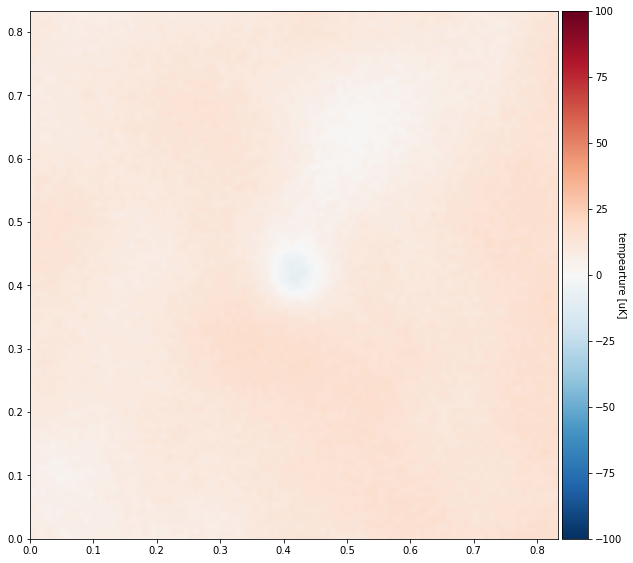

In [7]:

centering_errors_x = np.random.normal(0,2,Number_of_SZ_Clusters)
centering_errors_y = np.random.normal(0,2,Number_of_SZ_Clusters)
SZCat_centering_errs = SZCat
SZCat_centering_errs[0,:]  += centering_errors_x
SZCat_centering_errs[1,:]  += centering_errors_y

stack = Stack_on_Positions(total_map_plus_noise,N,SZCat_centering_errs,Number_of_SZ_Clusters,-100000,100000,50)
p = Plot_CMB_Map(stack,c_min/4.,c_max/4.,X_width*50*2/N,Y_width*50*2/N)





<font color='red'>EXCERCISE: </font>  Repeat excercise 18 with this centering error turned on.  Compare the results.  This is a prime example of systematics that must be accounted for in extracing SZ scaling relations through stacking.

In [12]:
## your code and plots go here

comment on your results here

## cross-corelation of optical and CMB maps

An alternative to stacking is cross correlation.  For example one can take an optical catalogue, make a map in the same pixelization as the CMB map or the density of sources (or sum of the masses or other property), smooth that map and take the power specturm using the tequncies we used for CMB analysis.

<font color='red'>EXCERCISE: </font>  Do this.


In [13]:
## your code here

your comments here.